In [72]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

### 1.1 Загрузка подмножества данных (11856 строк)

In [37]:
df = pd.read_csv('data/Train.csv', nrows = 18288)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ID         18288 non-null  int64         
 1   Count      18288 non-null  int64         
 2   Timestamp  18288 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 428.8 KB


In [64]:
df["Timestamp"] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')
date_time = pd.to_datetime(df.pop('Timestamp'), format='%d.%m.%Y %H:%M')

In [123]:
date_time

0       2012-08-25 00:00:00
1       2012-08-25 01:00:00
2       2012-08-25 02:00:00
3       2012-08-25 03:00:00
4       2012-08-25 04:00:00
                ...        
18283   2014-09-25 19:00:00
18284   2014-09-25 20:00:00
18285   2014-09-25 21:00:00
18286   2014-09-25 22:00:00
18287   2014-09-25 23:00:00
Name: Timestamp, Length: 18288, dtype: datetime64[ns]

In [66]:
df

,ID,Count
0,0,8
1,1,2
2,2,6
3,3,2
4,4,2
...,...,...
18283,18283,868
18284,18284,732
18285,18285,702
18286,18286,580


### 1.2 Разбиение на тренировочную и проверочную выборки

In [100]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [41]:
n

18288

### Нормализация данных

In [101]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,18288.0,9143.500000,5279.435197,0.0,4571.75,9143.5,13715.25,18287.0
Count,18288.0,138.958115,153.467461,2.0,22.00,84.0,210.00,1244.0


In [153]:
train_mean = train_df.mean(numeric_only=True)
train_std = train_df.std(numeric_only=True)

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [154]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,12801.0,0.0,1.0,-1.731848,-0.865924,0.000000,0.865924,1.731848
Count,12801.0,0.0,1.0,-0.896893,-0.736299,-0.388347,0.387855,8.872548


### 1. Индексы и смещения
Начните с создания класса WindowGenerator . Метод __init__ включает всю необходимую логику для индексов ввода и меток.

In [155]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [156]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Count'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Count']

In [157]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Count'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Count']

### 2. Сплит

In [158]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [159]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 2)
Inputs shape: (3, 6, 2)
Labels shape: (3, 1, 1)


### 3. Сюжет

In [160]:
w2.example = example_inputs, example_labels

In [161]:
def plot(self, model=None, plot_col='Count', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

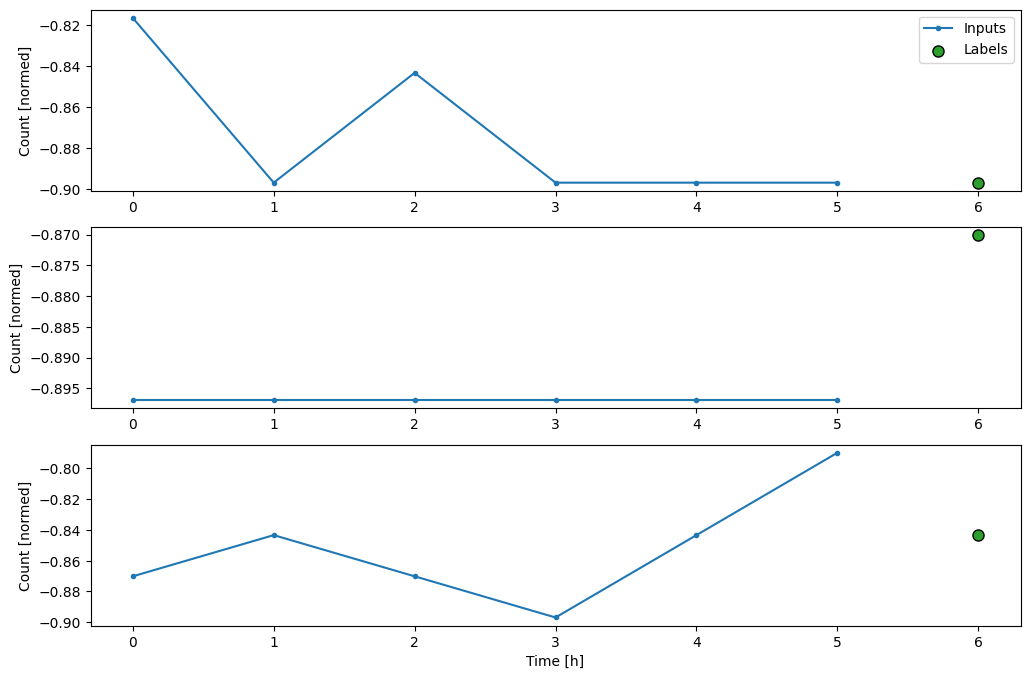

In [162]:
w2.plot()

### 4. Создайте tf.data.Dataset s
Наконец, этот метод make_dataset возьмет временной ряд DataFrame и преобразует его в tf.data.Dataset из пар (input_window, label_window) с помощью функции tf.keras.utils.timeseries_dataset_from_array :

In [163]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

Объект WindowGenerator содержит обучающие, проверочные и тестовые данные.

Добавьте свойства для доступа к ним как tf.data.Dataset с помощью метода make_dataset , который вы определили ранее. Кроме того, добавьте стандартный пакет примеров для быстрого доступа и построения графиков:

In [164]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Теперь объект WindowGenerator предоставляет вам доступ к объектам tf.data.Dataset , поэтому вы можете легко перебирать данные.

Свойство Dataset.element_spec сообщает вам структуру, типы данных и формы элементов набора данных.

In [165]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Итерация по Dataset дает конкретные партии:

In [166]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 2)
Labels shape (batch, time, features): (32, 1, 1)


## Одноступенчатые модели
Самая простая модель, которую вы можете построить на такого рода данных, — это модель, которая предсказывает значение одной функции — 1 временной шаг (один час) в будущее, основываясь только на текущих условиях.

Настройте объект WindowGenerator для создания этих одношаговых пар (input, label) :

In [167]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Count'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Count']

Объект window создает tf.data.Dataset из обучающих, проверочных и тестовых наборов, что позволяет легко перебирать пакеты данных.

In [168]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 2)
Labels shape (batch, time, features): (32, 1, 1)


### Базовый уровень

In [169]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [170]:
baseline = Baseline(label_index=column_indices['Count'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

115/115 [==============================] - 6s 52ms/step - loss: 0.4463 - mean_absolute_error: 0.4908


Итак, создайте более широкий WindowGenerator , который генерирует окна 24 часа последовательных входных данных и меток за раз. Новая переменная wide_window не меняет способ работы модели. Модель по-прежнему делает прогнозы на один час вперед на основе одного входного временного шага. Здесь time ось действует как batch ось: каждый прогноз делается независимо, без взаимодействия между временными шагами:

In [171]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Count'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Count']

In [172]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 2)
Output shape: (32, 24, 1)


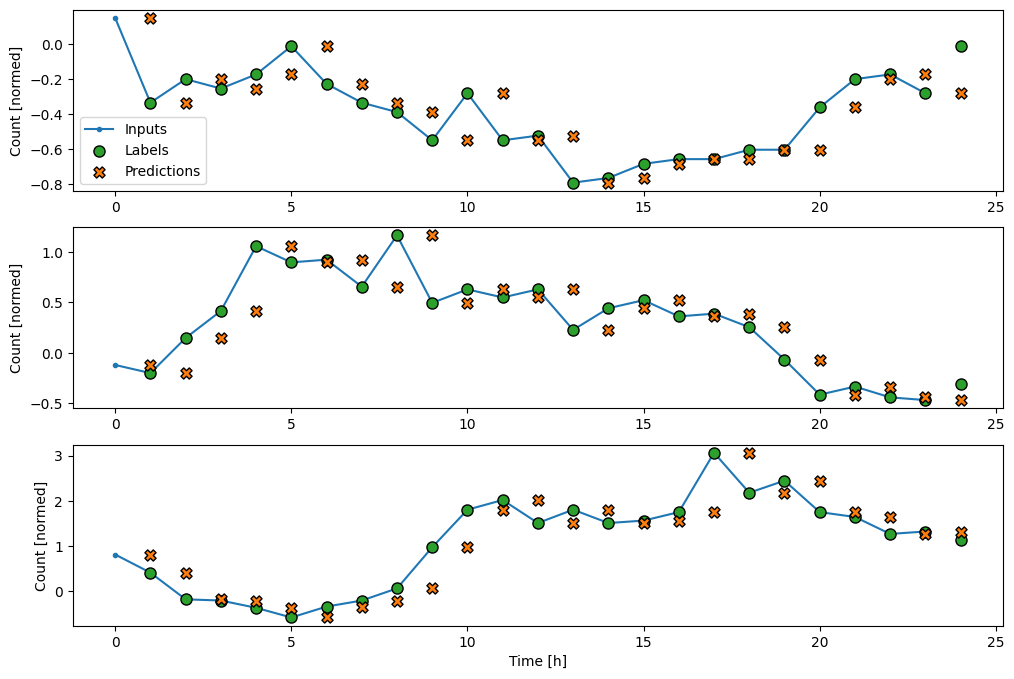

In [173]:
wide_window.plot(baseline)

### Линейная модель
Самая простая обучаемая модель, которую вы можете применить к этой задаче, — это вставить линейное преобразование между входом и выходом. В этом случае результат временного шага зависит только от этого шага

Слой tf.keras.layers.Dense без набора activation является линейной моделью. Слой преобразует только последнюю ось данных из (batch, time, inputs) в (batch, time, units) ; он применяется независимо к каждому элементу по осям batch и time .

In [174]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [175]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 2)
Output shape: (32, 1, 1)


In [176]:
##### Процедура обучения модели #####
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [177]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
400/400 [==============================] - 31s 76ms/step - loss: 4.0115 - mean_absolute_error: 1.6018 - val_loss: 23.7639 - val_mean_absolute_error: 4.2275
Epoch 2/20
400/400 [==============================] - 30s 74ms/step - loss: 2.0098 - mean_absolute_error: 1.1065 - val_loss: 11.9142 - val_mean_absolute_error: 2.8686
Epoch 3/20
400/400 [==============================] - 31s 76ms/step - loss: 0.9544 - mean_absolute_error: 0.7342 - val_loss: 5.6763 - val_mean_absolute_error: 1.8701
Epoch 4/20
400/400 [==============================] - 31s 76ms/step - loss: 0.4691 - mean_absolute_error: 0.4845 - val_loss: 2.7615 - val_mean_absolute_error: 1.2611
Epoch 5/20
400/400 [==============================] - 31s 76ms/step - loss: 0.2791 - mean_absolute_error: 0.3546 - val_loss: 1.5516 - val_mean_absolute_error: 0.9492
Epoch 6/20
400/400 [==============================] - 30s 75ms/step - loss: 0.2094 - mean_absolute_error: 0.3156 - val_loss: 1.0582 - val_mean_absolute_error: 0.7939
Ep

In [178]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 2)
Output shape: (32, 24, 1)


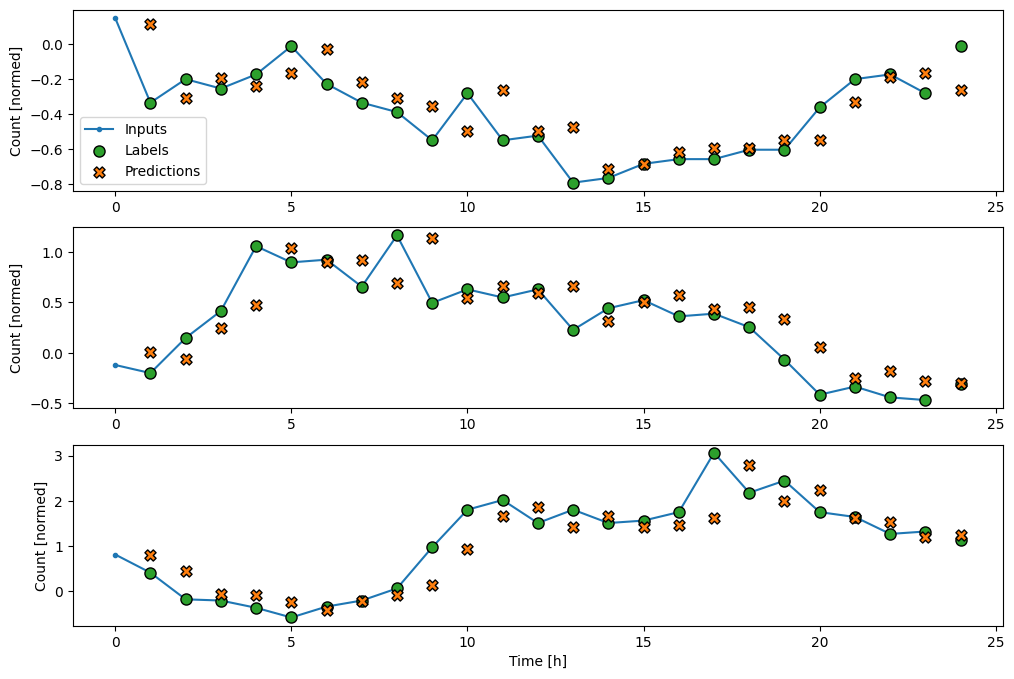

In [179]:
wide_window.plot(linear)

### Плотный

In [180]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
400/400 [==============================] - 32s 79ms/step - loss: 0.1349 - mean_absolute_error: 0.2164 - val_loss: 0.4282 - val_mean_absolute_error: 0.4910
Epoch 2/20
400/400 [==============================] - 34s 84ms/step - loss: 0.1064 - mean_absolute_error: 0.1923 - val_loss: 0.4448 - val_mean_absolute_error: 0.4870
Epoch 3/20
400/400 [==============================] - 34s 84ms/step - loss: 0.1062 - mean_absolute_error: 0.1922 - val_loss: 0.4258 - val_mean_absolute_error: 0.4794
Epoch 4/20
400/400 [==============================] - 34s 83ms/step - loss: 0.1063 - mean_absolute_error: 0.1929 - val_loss: 0.4240 - val_mean_absolute_error: 0.4802
Epoch 5/20
400/400 [==============================] - 32s 80ms/step - loss: 0.1058 - mean_absolute_error: 0.1919 - val_loss: 0.4347 - val_mean_absolute_error: 0.4958
Epoch 6/20
115/115 [==============================] - 7s 58ms/step - loss: 0.4359 - mean_absolute_error: 0.4934


### Многоступенчатый плотный
Одношаговая модель не имеет контекста для текущих значений входных данных. Он не может видеть, как входные объекты меняются с течением времени. Чтобы решить эту проблему, модели требуется доступ к нескольким временным шагам при прогнозировании:

In [181]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Count'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Count']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

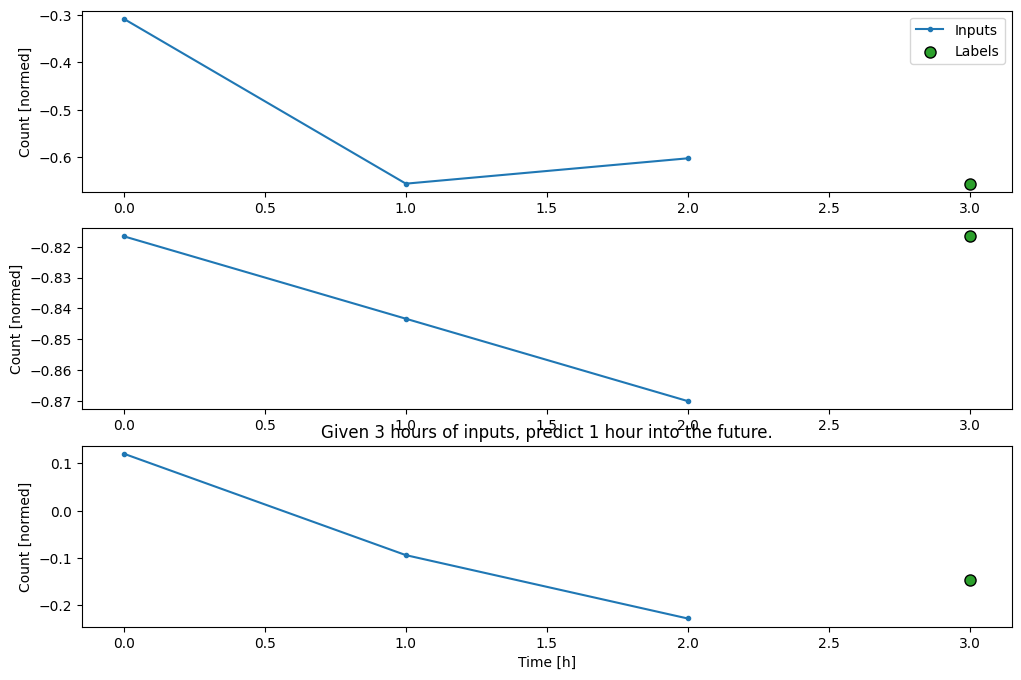

In [182]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [183]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [184]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 2)
Output shape: (32, 1, 1)


In [185]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

115/115 [==============================] - 7s 53ms/step - loss: 0.4190 - mean_absolute_error: 0.4874


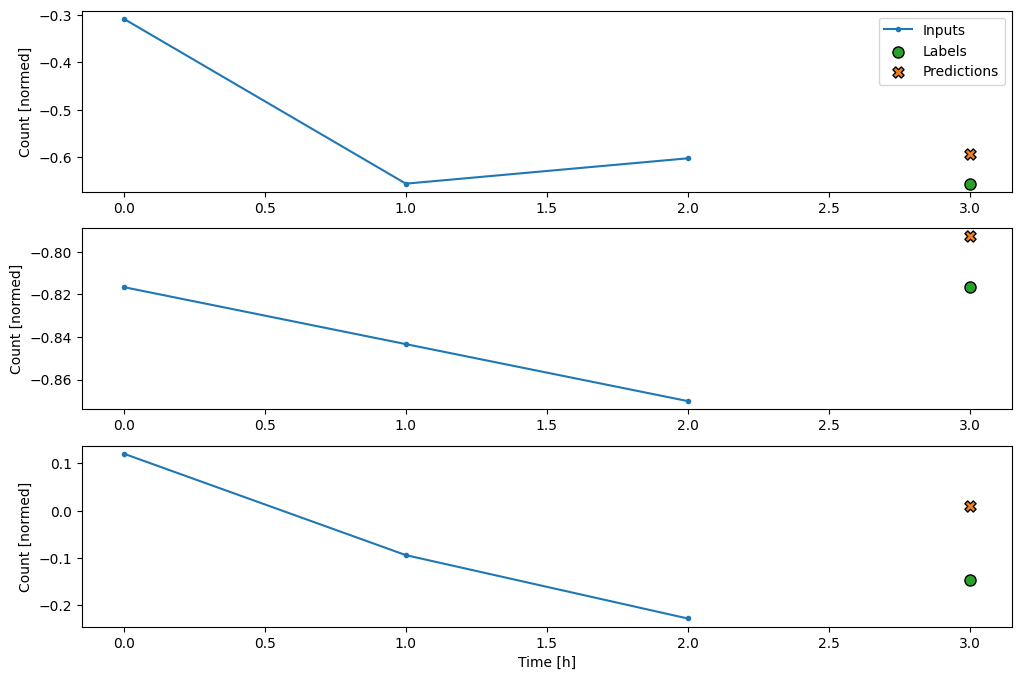

In [186]:
conv_window.plot(multi_step_dense)

Основным недостатком этого подхода является то, что результирующая модель может выполняться только на входных окнах именно такой формы.

## Сверточная нейронная сеть
Слой свертки ( tf.keras.layers.Conv1D ) также использует несколько временных шагов в качестве входных данных для каждого прогноза.

Ниже представлена ​​та же модель, что и в multi_step_dense , переписанная с помощью свертки.

Обратите внимание на изменения:

tf.keras.layers.Flatten и первый tf.keras.layers.Dense заменяются tf.keras.layers.Conv1D .
tf.keras.layers.Reshape больше не нужен, так как свертка сохраняет ось времени в своих выходных данных.

In [187]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [188]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 2)
Output shape: (32, 1, 1)


In [192]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

115/115 [==============================] - 7s 57ms/step - loss: 0.3946 - mean_absolute_error: 0.4592


In [193]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 2)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [194]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Count'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Count']

In [195]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 2)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


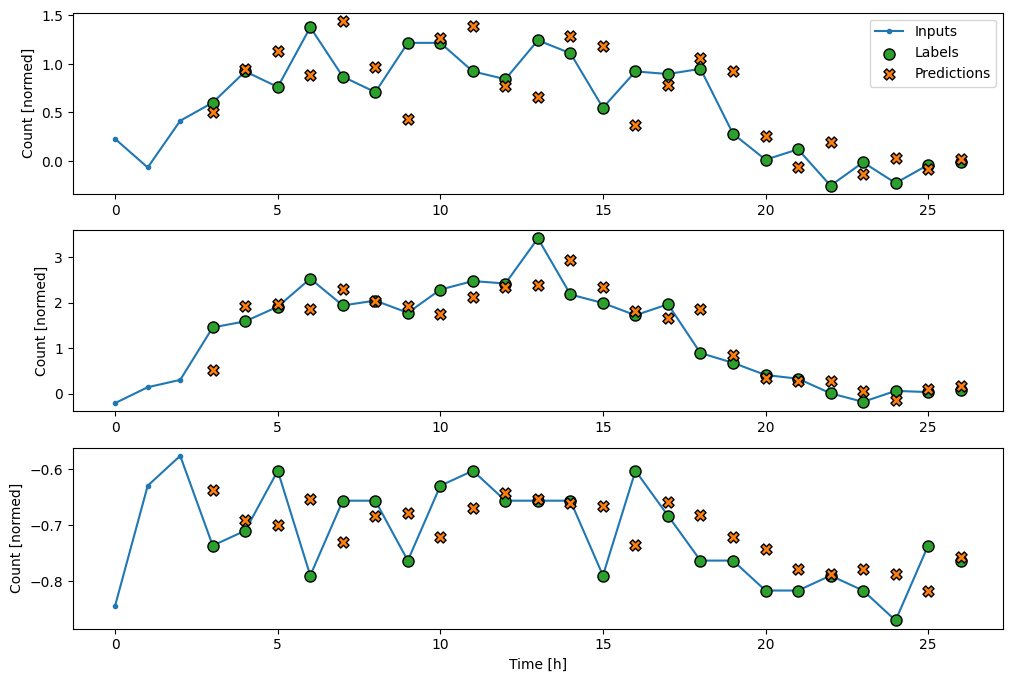

In [196]:
wide_conv_window.plot(conv_model)

## Рекуррентная нейронная сеть
Рекуррентная нейронная сеть (RNN) — это тип нейронной сети, хорошо подходящий для данных временных рядов. RNN обрабатывают временной ряд шаг за шагом, сохраняя внутреннее состояние от шага к шагу.

In [197]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [198]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 2)
Output shape: (32, 24, 1)


In [199]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

114/114 [==============================] - 9s 78ms/step - loss: 0.4909 - mean_absolute_error: 0.5012


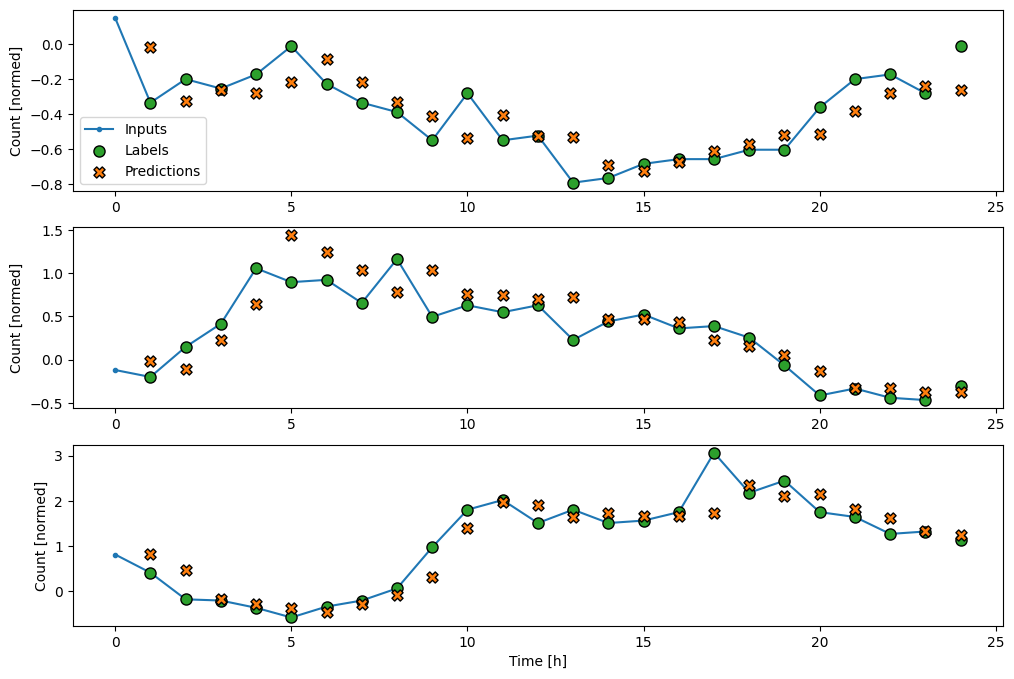

In [200]:
wide_window.plot(lstm_model)